Monthly gold prices since 1950 in USD (London market). Data is sourced from the Bundesbank.

# Imports

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [ ]:
from torch import nn
import torch.jit as jit
import torch.nn.functional as F
import numpy as np
from ray import tune

In [ ]:
from datetime import datetime

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
torch.autograd.set_detect_anomaly(True)

# NN classes

## Models and custom cells

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                # print("validation start")
                for x_val, y_val in val_loader:
                    # print("validation set", x_val, y_val)
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                # print("validation stop")
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
      with torch.no_grad():
          predictions = []
          values = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              predictions.append(yhat.detach().cpu().numpy())
              values.append(y_test.detach().cpu().numpy())

      return predictions, values

    def evaluateFromArrays(self, X, y, n_features=1):
      X = torch.Tensor(X)
      y = torch.Tensor(y)
      with torch.no_grad():
          prediction = None
          real = None
          x_test = X.view([1, -1, n_features]).to(device)
          y_test = y.to(device)
          self.model.eval()
          yhat = self.model(x_test)
          prediction = yhat.detach().cpu().numpy()
          real = y_test.detach().cpu().numpy()

      return prediction[0], real

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
class RNNModel(nn.Module):
    """
    Classic RNN model
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)

        return out

ResLSTM

In [ ]:
class ResLSTMLayer(nn.Module):
    """
    For this layer input_dim = hidden_dim = output_dim
    """
    def __init__(self, input_dim, dimension, layer_dim, dropout_prob, batch_first=True):
        super(ResLSTMLayer, self).__init__()
        print("Creating Residual LSTM", input_dim, dimension, layer_dim, dropout_prob)

        # LSTM layers
        self.lstm = nn.LSTM(input_dim, dimension, layer_dim, batch_first=batch_first, dropout=dropout_prob)
        self.lstm.to(device)

    def forward(self, x, bus):
        # print("forwarding inside residual layer")
        # print(x, h, c)
        h = bus[0]
        c = bus[1]
        out, (hn, cn) = self.lstm(x, (h, c))
        out = out + x

        return [out, (hn, cn)]

In [ ]:
class ResLSTMModel(nn.Module):
    """
    Basic residual LSTM model
    input_dim - dimension of input
    hidden_dim - dimension of hidden layers
    layer_dim - layers count between shortcut connections
    layers_count - count of residual blocks
    output_dim - dimension of output
    dropout_prob - dropout probability on each layer
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, layers_count, output_dim, dropout_prob):
        super(ResLSTMModel, self).__init__()
        print("Creating Residual LSTM model", input_dim, hidden_dim, layer_dim, layers_count, output_dim, dropout_prob)

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.shortcut_layer_dim = layer_dim
        self.layer_dim = layer_dim

        self.layers = []
        reslstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first=True)
        reslstm.to(device)
        self.layers.append(reslstm)
        for i in range(layers_count-1):
          reslstm = ResLSTMLayer(hidden_dim, hidden_dim, layer_dim, dropout_prob, batch_first=True)
          reslstm.to(device)
          self.layers.append(reslstm)

        # final lstm layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first=True)
        self.lstm.to(device)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        for layer in self.layers:
          # print("forwarding full layer")
          x, bus = layer(x, (h0.detach(), c0.detach()))
          h0, c0 = bus[0], bus[1]
          

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

## Ensembles

Stack creator

In [ ]:
class Stack(nn.Module):
    def __init__(self, models, hidden_dim, output_dim, disable_grad_f):
        super(Stack,self).__init__()
        self.models = list(map(disable_grad_f, models))
        
        self.l_in = nn.Linear(len(self.models)*output_dim, hidden_dim, bias=False)        
        self.l_out = nn.Linear(hidden_dim, output_dim, bias=False)

        print("models count in stack:", len(self.models))
          
    def forward(self,x):
      outputs = []
      for net in self.models: outputs.append(net(x))
      # print(len(outputs), outputs[0].shape)
      out = torch.cat(outputs, 1)
      out1 = F.relu(self.l_in(out))
      out2 = self.l_out(out1)
      return out2

Averaging ensemble

In [ ]:
from functools import reduce

In [ ]:
class SumEnsemble(nn.Module):
    def __init__(self, models, hidden_dim, output_dim, disable_grad_f):
        super(SumEnsemble, self).__init__()
        self.models = list(map(disable_grad_f, models))

        self.l_in = nn.Linear(output_dim, hidden_dim, bias=False)  
        self.l_out = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        outputs = []
        for net in self.models: outputs.append(net(x))
        out = reduce(lambda x, y: x+y, outputs)
        out1 = F.relu(self.l_in(out))
        out2 = self.l_out(out1)
        return out2

# Helper functions

In [ ]:
!mkdir models

In [ ]:
def createDataset(dataset, input_n, horizon):
    X, y, div = [], [], []
    for i in range(len(dataset)-horizon-input_n):
        # print(f"x: {i}:{i+input_n}; y: {i+input_n}:{i+input_n+horizon}")
        feature = dataset.iloc[i:i+input_n]
        target = dataset.iloc[i+input_n:i+input_n+horizon]
        # print(feature, "=>", target)
        div.append(feature.iloc[-1].value)
        # target = target / feature.iloc[-1]
        # feature = feature / feature.iloc[-1]
        X.append(feature["value"].values)
        y.append(target["value"].values)
    X, y = pd.DataFrame(X, columns =[f"I{i}" for i in range(input_n)]), pd.DataFrame(y, columns =[f"H{i}" for i in range(horizon)])
    return (X, y, div)

def train_val_test_split(X, y, val_ratio):
    X_test, y_test = X.iloc[-1], y.iloc[-1]
    X_train, X_val, y_train, y_val = train_test_split(X.iloc[:-1], y.iloc[:-1], test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler=None, concat=None):
    if concat is not None:
      values = np.concatenate(values, axis=concat).ravel()
      predictions = np.concatenate(predictions, axis=concat).ravel()
    df_result = pd.DataFrame(data={"value": values, "prediction": predictions}, index=df_test.head(len(values)).index)
    df_result = df_result.sort_index()
    if scaler is not None: df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return{
        'mae' : mean_absolute_error(df.value, df.prediction),
        'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5
    }
            # 'r2' : r2_score(df.value, df.prediction)}

In [ ]:
def scaleData(scaler, X_train, X_val, X_test, y_train, y_val, y_test):
  X_train_arr = scaler.fit_transform(X_train)
  X_val_arr = scaler.transform(X_val)
  X_test_arr = scaler.transform(X_test)

  y_train_arr = scaler.fit_transform(y_train)
  y_val_arr = scaler.transform(y_val)
  y_test_arr = scaler.transform(y_test)
  return (X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr)

In [ ]:
def createTrainers(X_train_arr, y_train_arr, X_val_arr, y_val_arr, batch_size):
  train_features = torch.Tensor(X_train_arr)
  train_targets = torch.Tensor(y_train_arr)
  val_features = torch.Tensor(X_val_arr)
  val_targets = torch.Tensor(y_val_arr)

  train = TensorDataset(train_features, train_targets)
  val = TensorDataset(val_features, val_targets)

  train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

  return (train_loader, val_loader)

# Data

In [ ]:
!wget https://raw.githubusercontent.com/datasets/gold-prices/main/data/monthly.csv -O gold_m.csv

--2023-04-30 18:10:31--  https://raw.githubusercontent.com/datasets/gold-prices/main/data/monthly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13863 (14K) [text/plain]
Saving to: ‘gold_m.csv’

gold_m.csv          100%[===================>]  13.54K  --.-KB/s    in 0s      

2023-04-30 18:10:31 (80.2 MB/s) - ‘gold_m.csv’ saved [13863/13863]



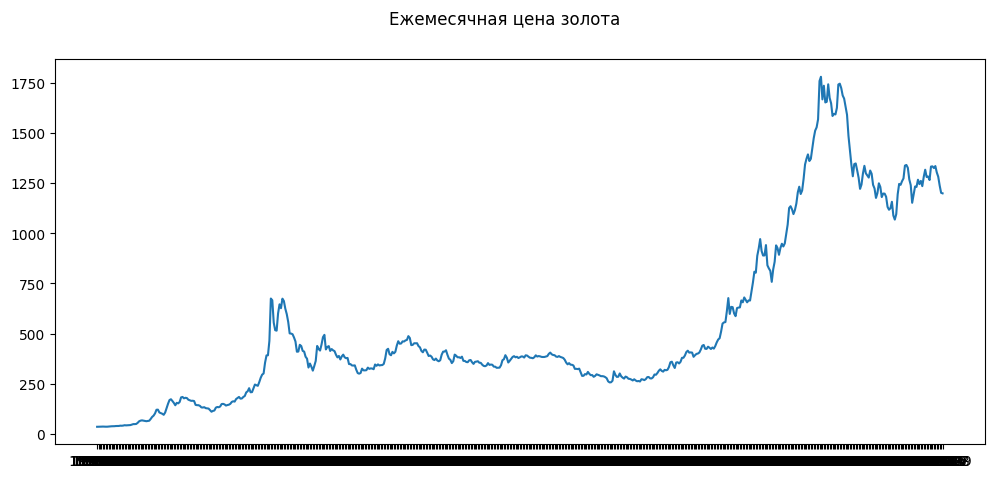

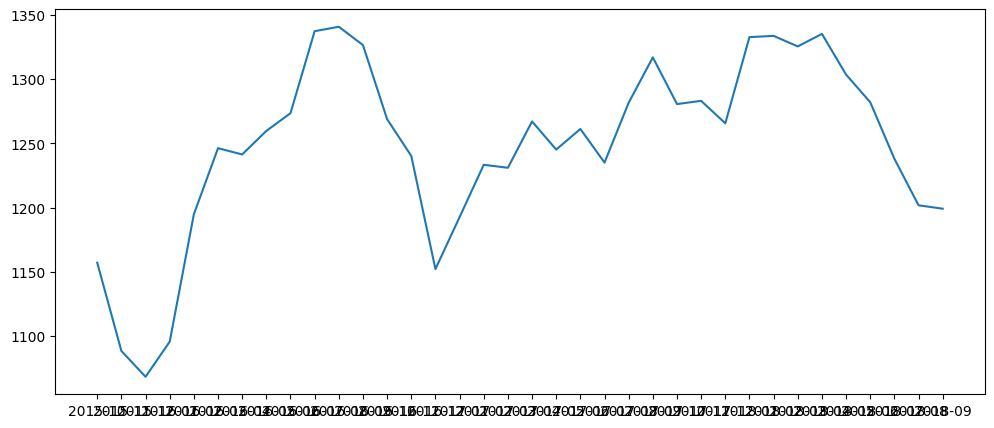

In [ ]:
dohody = pd.read_table('gold_m.csv', delimiter=',')[20*12:]
# dohody[0] = pd.date_range(start='1/1993', end= '2/2019', freq = 'M')
dohody = dohody.set_index(['Date'])
dohody = dohody.rename(columns={'Price': 'value'})

plt.figure(figsize=(12, 5))
plt.plot(dohody)
plt.suptitle('Ежемесячная цена золота')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dohody.tail(36))
plt.show()

In [ ]:
dohody

,value
Date,
1970-01,34.946
1970-02,34.994
1970-03,35.089
1970-04,35.623
1970-05,35.958
...,...
2018-05,1303.618
2018-06,1282.126
2018-07,1238.064


Lets deseason data

In [ ]:
df = dohody

In [ ]:
# Trend, seasional and residual values
res = STL(df, period = 12).fit()
trend = res.trend
seasonal = res.seasonal
residual = res.resid
deseasoned = trend + residual

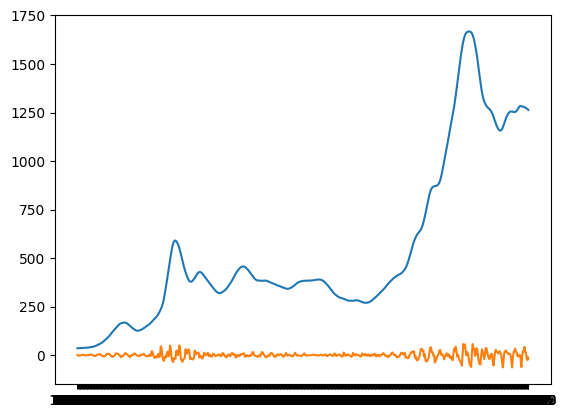

In [ ]:
plt.plot(trend)
plt.plot(seasonal)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(deseasoned.values.reshape(-1, 1))
df = pd.DataFrame(np.transpose([deseasoned.index, scaler.transform(deseasoned.values.reshape(-1, 1)).reshape(585,)]), columns=["Date", "value"])
df = df.set_index(['Date'])
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()

<ipython-input-29-833f4f2345b6>:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not df.index.is_monotonic:


In [ ]:
df["value"]

Date
1970-01-01    0.000062
1970-02-01    0.001141
1970-03-01    0.002445
1970-04-01    0.002752
1970-05-01    0.001793
                ...   
2018-05-01    0.730616
2018-06-01    0.720424
2018-07-01    0.712772
2018-08-01    0.695829
2018-09-01    0.686885
Name: value, Length: 585, dtype: object

In [ ]:
input_dim = 24
outpur_dim = 12
X, y, div = createDataset(df, input_dim, outpur_dim)

In [ ]:
# X = X.applymap(np.log)
# y = y.applymap(np.log)
X

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I14,I15,I16,I17,I18,I19,I20,I21,I22,I23
0,0.000062,0.001141,0.002445,0.002752,0.001793,0.000999,0.000000,0.000054,0.000196,0.001177,...,0.002975,0.003049,0.003009,0.001786,0.002517,0.004562,0.005182,0.006211,0.007776,0.008265
1,0.001141,0.002445,0.002752,0.001793,0.000999,0.000000,0.000054,0.000196,0.001177,0.003020,...,0.003049,0.003009,0.001786,0.002517,0.004562,0.005182,0.006211,0.007776,0.008265,0.008553
2,0.002445,0.002752,0.001793,0.000999,0.000000,0.000054,0.000196,0.001177,0.003020,0.003752,...,0.003009,0.001786,0.002517,0.004562,0.005182,0.006211,0.007776,0.008265,0.008553,0.007991
3,0.002752,0.001793,0.000999,0.000000,0.000054,0.000196,0.001177,0.003020,0.003752,0.002982,...,0.001786,0.002517,0.004562,0.005182,0.006211,0.007776,0.008265,0.008553,0.007991,0.006522
4,0.001793,0.000999,0.000000,0.000054,0.000196,0.001177,0.003020,0.003752,0.002982,0.002993,...,0.002517,0.004562,0.005182,0.006211,0.007776,0.008265,0.008553,0.007991,0.006522,0.007041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.670090,0.664773,0.632117,0.620288,0.630099,0.655188,0.634880,0.640009,0.631638,0.668318,...,0.756968,0.757434,0.749837,0.720185,0.719386,0.689147,0.684306,0.689557,0.687243,0.699614
545,0.664773,0.632117,0.620288,0.630099,0.655188,0.634880,0.640009,0.631638,0.668318,0.695520,...,0.757434,0.749837,0.720185,0.719386,0.689147,0.684306,0.689557,0.687243,0.699614,0.696400
546,0.632117,0.620288,0.630099,0.655188,0.634880,0.640009,0.631638,0.668318,0.695520,0.689726,...,0.749837,0.720185,0.719386,0.689147,0.684306,0.689557,0.687243,0.699614,0.696400,0.707683
547,0.620288,0.630099,0.655188,0.634880,0.640009,0.631638,0.668318,0.695520,0.689726,0.705862,...,0.720185,0.719386,0.689147,0.684306,0.689557,0.687243,0.699614,0.696400,0.707683,0.702847


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
print(list(map(len, (X_train, X_val, X_test, y_train, y_val, y_test))))
# scaler = MinMaxScaler()
# X_train_arr, X_val_arr, y_train_arr, y_val_arr = scaleData(scaler, X_train, X_val, y_train, y_val)
# batch_size = 32
# train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

[438, 110, 24, 438, 110, 12]


# ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [ ]:
x_train = df[:-12]

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(x_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q = 3, m = 12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1386.278, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2906.831, Time=3.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1362.889, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-2657.542, Time=0.38 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-3030.946, Time=8.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-1406.352, Time=1.87 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-3075.964, Time=6.62 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-2942.053, Time=6.46 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.22 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

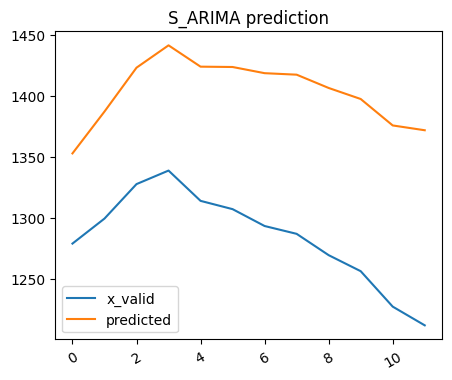

{'mae': 119.03931805785665, 'rmse': 121.61983503164376}


In [ ]:
# Forecast
fitted, confint = smodel.predict(12, return_conf_int = True)

# make series for plotting purpose
fitted_series = pd.Series(fitted)
lower_series = pd.Series(confint[:, 0])
upper_series = pd.Series(confint[:, 1])

fitted = scaler.inverse_transform(fitted.values.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(df[-12:].values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(fitted, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("S_ARIMA prediction")
plt.show()

print(
    {
        'mae' : mean_absolute_error(values, fitted),
        'rmse' : mean_squared_error(values, fitted) ** 0.5
    }
)

# ETS

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


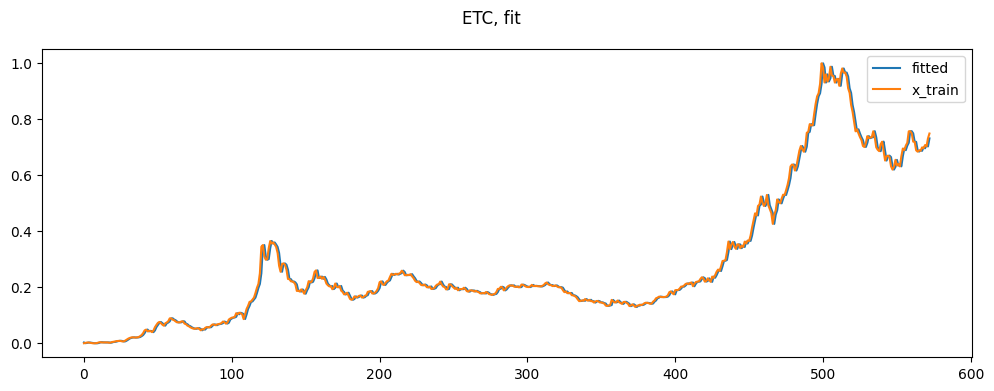

In [ ]:
model = ETSModel(x_train.values.reshape(-1),
                seasonal='add',
                seasonal_periods=12)
fit = model.fit(maxiter = 10)

# spots.plot(label="data")
fitted = fit.fittedvalues

plt.figure(figsize = (12, 4))
plt.plot(fitted, label = 'fitted')
plt.plot(x_train.values.reshape(-1), label = 'x_train')
plt.suptitle('ETC, fit')
plt.legend()
plt.show()



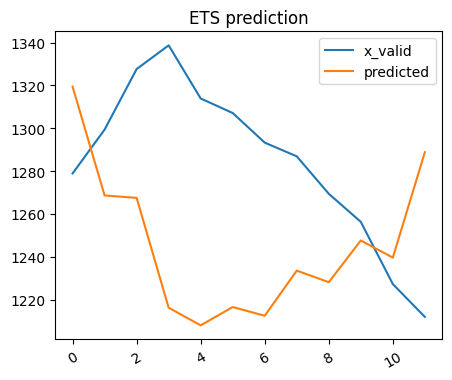

{'mae': 60.34444040329, 'rmse': 69.46915189766786}


In [ ]:
fitted = fit.predict()[-12:]
fitted = scaler.inverse_transform(fitted.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(df[-12:].values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(fitted, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ETS prediction")
plt.show()

print(
    {
        'mae' : mean_absolute_error(values, fitted),
        'rmse' : mean_squared_error(values, fitted) ** 0.5
    }
)

# Tuning Basic

## LSTM

[1/24] Training loss: 0.0336	 Validation loss: 0.5157
[2/24] Training loss: 0.0208	 Validation loss: 0.4107
[3/24] Training loss: 0.0064	 Validation loss: 0.2818
[4/24] Training loss: 0.0080	 Validation loss: 0.2949
[5/24] Training loss: 0.0071	 Validation loss: 0.2753
[6/24] Training loss: 0.0072	 Validation loss: 0.2619
[7/24] Training loss: 0.0069	 Validation loss: 0.2427
[8/24] Training loss: 0.0066	 Validation loss: 0.2197
[9/24] Training loss: 0.0063	 Validation loss: 0.1929
[10/24] Training loss: 0.0061	 Validation loss: 0.1677


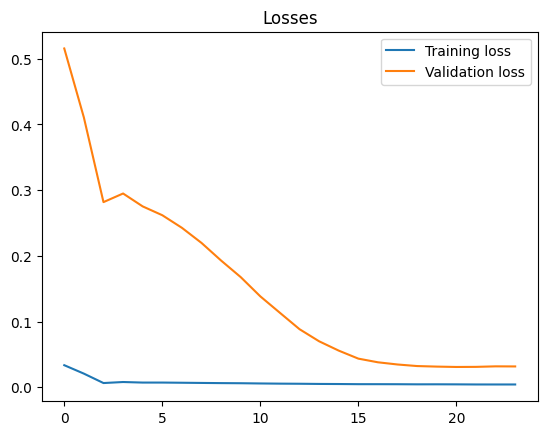

PRED: [1440.938  1561.9463 1361.3922 1322.7208 1521.9818 1339.8147 1376.4
 1380.2104 1264.7457 1266.7703 1359.1489 1294.512 ]
REAL: [1318.6101 1278.9132 1299.4064 1327.6642 1338.7513 1313.9275 1307.1349
 1293.3082 1286.8975 1269.4181 1256.2949 1227.2383]


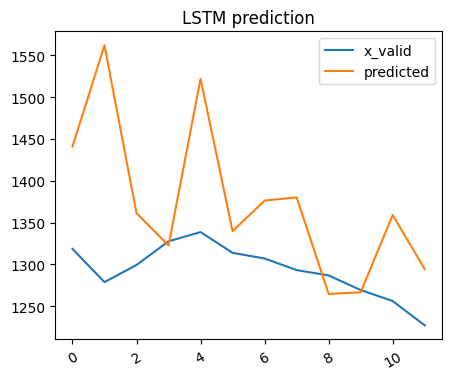

{'mae': 86.04187, 'rmse': 115.87857751354433}


In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 512
layer_dim = 6
dropout = 0.1
n_epochs = 24
learning_rate = 0.0001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = LSTMModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
# loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## GRU

[1/24] Training loss: 0.0152	 Validation loss: 0.2143
[2/24] Training loss: 0.0035	 Validation loss: 0.1447
[3/24] Training loss: 0.0034	 Validation loss: 0.1212
[4/24] Training loss: 0.0035	 Validation loss: 0.1134
[5/24] Training loss: 0.0032	 Validation loss: 0.0985
[6/24] Training loss: 0.0030	 Validation loss: 0.0838
[7/24] Training loss: 0.0028	 Validation loss: 0.0728
[8/24] Training loss: 0.0026	 Validation loss: 0.0607
[9/24] Training loss: 0.0025	 Validation loss: 0.0528
[10/24] Training loss: 0.0024	 Validation loss: 0.0441


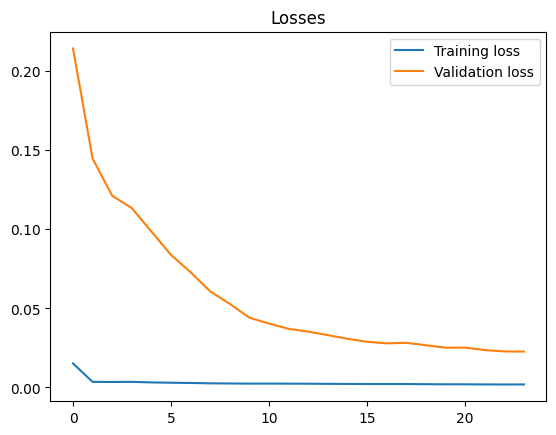

PRED: [1065.2211  1048.4972  1042.4968  1023.6902  1029.48    1018.899
  989.3553  1004.75885  983.0737   959.246    944.72595  931.3093 ]
REAL: [1318.6101 1278.9132 1299.4064 1327.6642 1338.7513 1313.9275 1307.1349
 1293.3082 1286.8975 1269.4181 1256.2949 1227.2383]


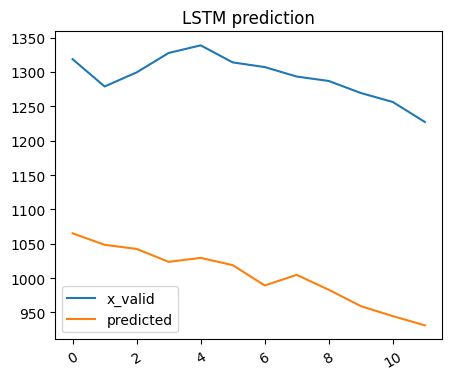

{'mae': 289.73425, 'rmse': 290.94677079751204}


In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 512
layer_dim = 6
dropout = 0.1
n_epochs = 24
learning_rate = 0.0001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRUModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## RNN

[1/12] Training loss: 0.0053	 Validation loss: 0.1579
[2/12] Training loss: 0.0039	 Validation loss: 0.1349
[3/12] Training loss: 0.0038	 Validation loss: 0.1170
[4/12] Training loss: 0.0032	 Validation loss: 0.0853
[5/12] Training loss: 0.0025	 Validation loss: 0.0438
[6/12] Training loss: 0.0025	 Validation loss: 0.0321
[7/12] Training loss: 0.0030	 Validation loss: 0.0516
[8/12] Training loss: 0.0023	 Validation loss: 0.0481
[9/12] Training loss: 0.0020	 Validation loss: 0.0377
[10/12] Training loss: 0.0021	 Validation loss: 0.0361


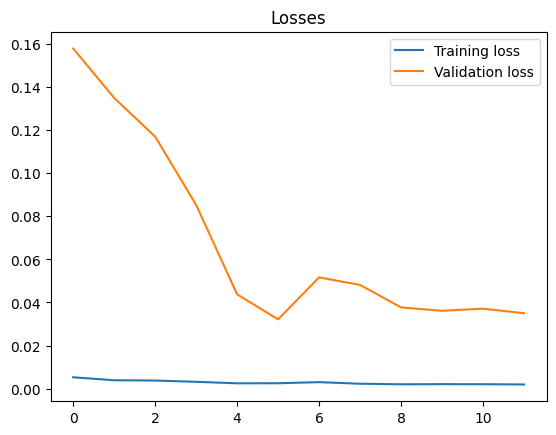

PRED: [955.6098  945.68335 945.0471  941.13617 918.74744 903.4347  892.1233
 889.05133 857.3695  871.59033 848.2319  831.69855]
REAL: [1318.6101 1278.9132 1299.4064 1327.6642 1338.7513 1313.9275 1307.1349
 1293.3082 1286.8975 1269.4181 1256.2949 1227.2383]


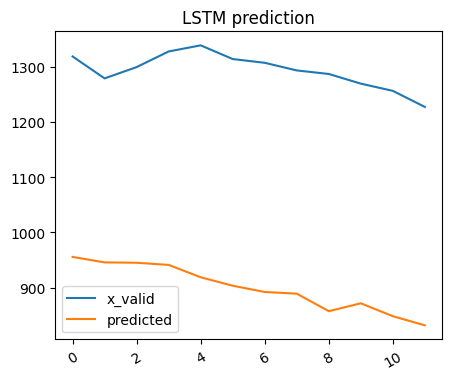

{'mae': 393.1534, 'rmse': 394.1319377759179}


In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 512
layer_dim = 6
dropout = 0.1
n_epochs = 12
learning_rate = 0.00008
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## ResLSTM

Creating Residual LSTM model 24 512 1 6 12 0.1
Creating Residual LSTM 512 512 1 0.1
Creating Residual LSTM 512 512 1 0.1
Creating Residual LSTM 512 512 1 0.1
Creating Residual LSTM 512 512 1 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Creating Residual LSTM 512 512 1 0.1
[1/24] Training loss: 0.0155	 Validation loss: 0.2358
[2/24] Training loss: 0.0088	 Validation loss: 0.2549
[3/24] Training loss: 0.0060	 Validation loss: 0.2070
[4/24] Training loss: 0.0060	 Validation loss: 0.1822
[5/24] Training loss: 0.0054	 Validation loss: 0.1539
[6/24] Training loss: 0.0050	 Validation loss: 0.1283
[7/24] Training loss: 0.0045	 Validation loss: 0.1044
[8/24] Training loss: 0.0042	 Validation loss: 0.0831
[9/24] Training loss: 0.0039	 Validation loss: 0.0653
[10/24] Training loss: 0.0037	 Validation loss: 0.0519


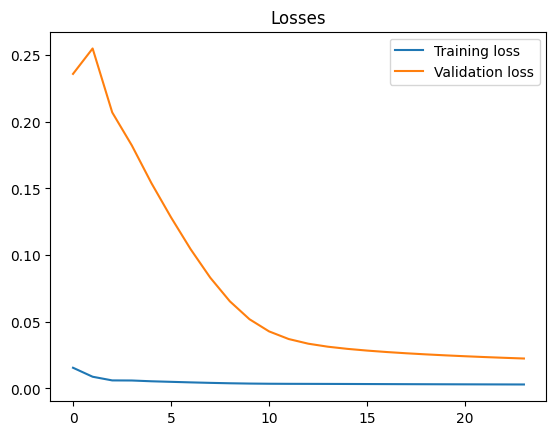

PRED: [1195.8876 1186.1824 1178.5918 1170.6189 1160.277  1149.0509 1134.2767
 1129.9237 1116.9518 1108.47   1097.4121 1081.8339]
REAL: [1318.6101 1278.9132 1299.4064 1327.6642 1338.7513 1313.9275 1307.1349
 1293.3082 1286.8975 1269.4181 1256.2949 1227.2383]
{'mae': 150.674, 'rmse': 152.67150320418347}


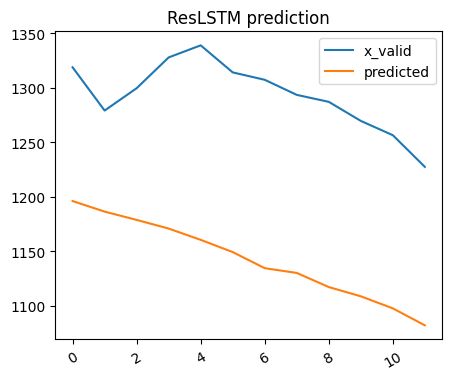

{'mae': 150.674, 'rmse': 152.67150320418347}


In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 512
layer_dim = 1
layers_count = 6
dropout = 0.1
n_epochs = 24
learning_rate = 0.0003
weight_decay = 1e-6

# input_dim, hidden_dim, shortcut_layer_dim, layers_count, output_dim, dropout_prob

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                "layers_count" : layers_count, 
                'output_dim' : output_dim,
                'dropout_prob' : dropout
                }

model = ResLSTMModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.HuberLoss(delta=1.1)
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Ensembles

In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

## Residual LSTM

In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 512
layer_dim = 1
layers_count = 6
dropout = 0.1
n_epochs = 24
learning_rate = 0.0003
weight_decay = 1e-6

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
models = []
layer_props = (96, 1, 4)
for i in range(10):
  hidden_dim, layer_dim, layers_count = layer_props
  model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    "layers_count" : layers_count, 
    'output_dim' : output_dim,
    'dropout_prob' : dropout
  }
  model = ResLSTMModel(**model_params)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  models.append(opt)
  print(f"Trained model with h={hidden_dim} l={layer_dim}")

Creating Residual LSTM model 24 96 1 4 12 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/24] Training loss: 0.0331	 Validation loss: 0.4885
[2/24] Training loss: 0.0164	 Validation loss: 0.3901
[3/24] Training loss: 0.0076	 Validation loss: 0.3166
[4/24] Training loss: 0.0069	 Validation loss: 0.2936
[5/24] Training loss: 0.0071	 Validation loss: 0.2863
[6/24] Training loss: 0.0069	 Validation loss: 0.2779
[7/24] Training loss: 0.0067	 Validation loss: 0.2688
[8/24] Training loss: 0.0066	 Validation loss: 0.2599
[9/24] Training loss: 0.0064	 Validation loss: 0.2510
[10/24] Training loss: 0.0063	 Validation loss: 0.2423
Trained model with h=96 l=1
Creating Residual LSTM model 24 96 1 4 12 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
[1/24] Training loss: 0.0372	 Validation loss: 0.5075
[2/24] Training loss: 0.0208	 Validation loss: 0.4109
[3/24] Training loss: 0.0088	 Validation loss: 0.3157
[4/24] Training loss: 0.0064	 Validation loss: 0.2761
[5/24] Training loss: 0.0067	 Validation loss: 0.2661
[6/24] Tra

models count in stack: 10
[1/5] Training loss: 0.0151	 Validation loss: 0.1535
[2/5] Training loss: 0.0036	 Validation loss: 0.0794
[3/5] Training loss: 0.0040	 Validation loss: 0.0869
[4/5] Training loss: 0.0038	 Validation loss: 0.0881
[5/5] Training loss: 0.0038	 Validation loss: 0.0869


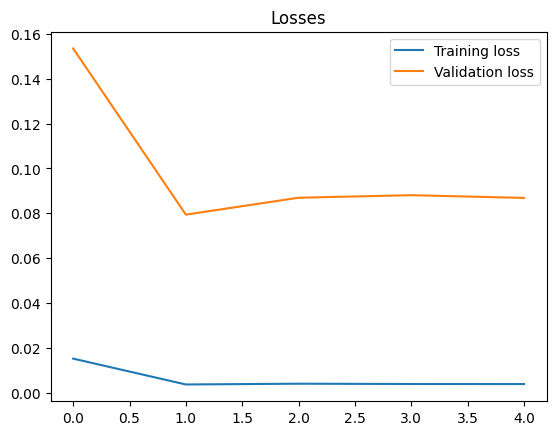

PRED: [847.3925  838.2329  831.2629  819.3615  838.42126 876.10724 845.29205
 846.7483  847.90753 835.3747  857.6475  863.06104]
REAL: [1318.6101 1278.9132 1299.4064 1327.6642 1338.7513 1313.9275 1307.1349
 1293.3082 1286.8975 1269.4181 1256.2949 1227.2383]
{'mae': 447.5629, 'rmse': 449.18045162829605}


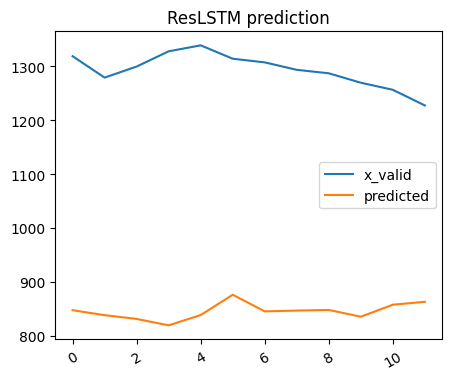

In [ ]:
def disable_grad(layer):
    for _layer in layer.layers:
      for p in _layer.parameters():
          p.requires_grad=False
    for p in layer.parameters():
          p.requires_grad=False
    return layer

learning_rate = 0.0001
model = Stack(list(map(lambda x: x.model, models)), 512, output_dim, disable_grad)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=5, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

## Basic LSTM

In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 512
layer_dim = 6
dropout = 0.1
n_epochs = 24
learning_rate = 0.0001
weight_decay = 1e-6

loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
models = []
layer_props = (96, 3, 3)
for i in range(8):
  hidden_dim, layer_dim, layers_count = layer_props
  model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    # "layers_count" : layers_count, 
    'output_dim' : output_dim,
    'dropout_prob' : dropout
  }
  model = LSTMModel(**model_params)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  models.append(opt)
  print(f"Trained model with h={hidden_dim} l={layer_dim}")

[1/24] Training loss: 0.0200	 Validation loss: 0.2724
[2/24] Training loss: 0.0180	 Validation loss: 0.2636
[3/24] Training loss: 0.0160	 Validation loss: 0.2531
[4/24] Training loss: 0.0138	 Validation loss: 0.2387
[5/24] Training loss: 0.0113	 Validation loss: 0.2169
[6/24] Training loss: 0.0083	 Validation loss: 0.1843
[7/24] Training loss: 0.0055	 Validation loss: 0.1431
[8/24] Training loss: 0.0036	 Validation loss: 0.1068
[9/24] Training loss: 0.0029	 Validation loss: 0.0872
[10/24] Training loss: 0.0027	 Validation loss: 0.0792
Trained model with h=96 l=3
[1/24] Training loss: 0.0205	 Validation loss: 0.2740
[2/24] Training loss: 0.0187	 Validation loss: 0.2661
[3/24] Training loss: 0.0168	 Validation loss: 0.2562
[4/24] Training loss: 0.0146	 Validation loss: 0.2415
[5/24] Training loss: 0.0118	 Validation loss: 0.2175
[6/24] Training loss: 0.0085	 Validation loss: 0.1791
[7/24] Training loss: 0.0052	 Validation loss: 0.1306
[8/24] Training loss: 0.0031	 Validation loss: 0.0929

models count in stack: 8
[1/8] Training loss: 0.0360	 Validation loss: 0.4547
[2/8] Training loss: 0.0229	 Validation loss: 0.3342
[3/8] Training loss: 0.0141	 Validation loss: 0.2409
[4/8] Training loss: 0.0086	 Validation loss: 0.1740
[5/8] Training loss: 0.0058	 Validation loss: 0.1314
[6/8] Training loss: 0.0046	 Validation loss: 0.1072
[7/8] Training loss: 0.0042	 Validation loss: 0.0946
[8/8] Training loss: 0.0041	 Validation loss: 0.0884


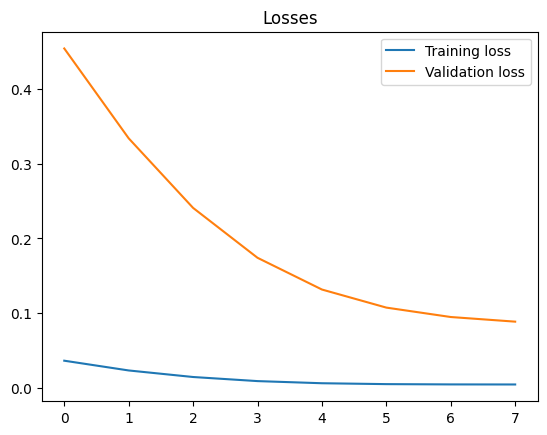

PRED: [835.9426  835.69257 820.2316  829.22925 820.05505 812.0191  831.77106
 838.17847 916.50745 852.78265 906.4438  879.3473 ]
REAL: [1318.6101 1278.9132 1299.4064 1327.6642 1338.7513 1313.9275 1307.1349
 1293.3082 1286.8975 1269.4181 1256.2949 1227.2383]
{'mae': 444.947, 'rmse': 448.6765260184669}


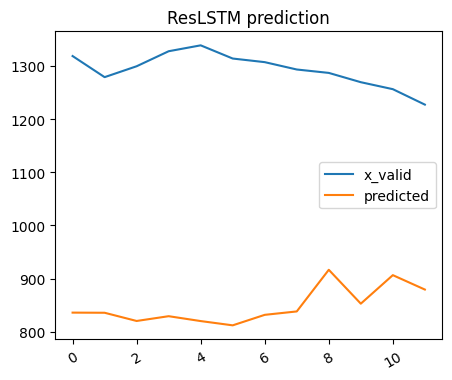

In [ ]:
def disable_grad(layer):
    for p in layer.parameters():
          p.requires_grad=False
    return layer

learning_rate = 0.00006
model = Stack(list(map(lambda x: x.model, models)), 256, output_dim, disable_grad)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=8, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

# Summary

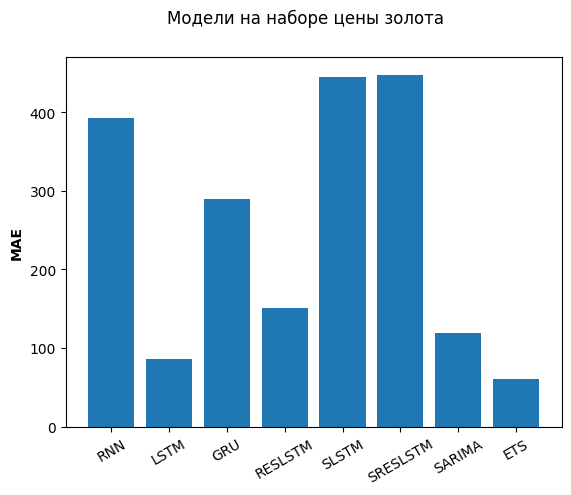

In [3]:
yt = [ 393.153,  86.042, 289.734, 150.674, 444.947, 447.563, 119.039, 60.344]

xt = [r for r in range(len(yt))]

xlabels =  ['RNN', 'LSTM', 'GRU', 'RESLSTM', 'SLSTM', 'SRESLSTM', 'SARIMA', 'ETS']

plt.bar(xt, yt)
plt.xticks(xt, xlabels[: len(yt)])
plt.ylabel('MAE', fontweight ='bold')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.suptitle('Модели на наборе цены золота')

plt.show()